# Cell segmentation in two-photon stacks
We train a fully convolutional network to perform cell segmentation (soma vs background) in a 3-d stack; it requires isotropic inputs at 1 um^3 resolution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load network
import segmentation.bl3d.models as segmodels

net = segmodels.FullyConvNet(use_batchnorm=True)
net.load_state_dict(torch.load('../data/model_fcn986-122-1.pth'))
net.to(device)
net.eval()
print(net)

FullyConvNet(
  (fcn): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace)
    (2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU(inplace)
    (5): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2), dilation=(2, 2, 2))
    (7): ReLU(inplace)
    (8): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2), dilation=(2, 2, 2))
    (10): ReLU(inplace)
    (11): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 3, 3), dilation=(3, 3, 3))
    (13): ReLU(inplace)
    (14): BatchNo

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


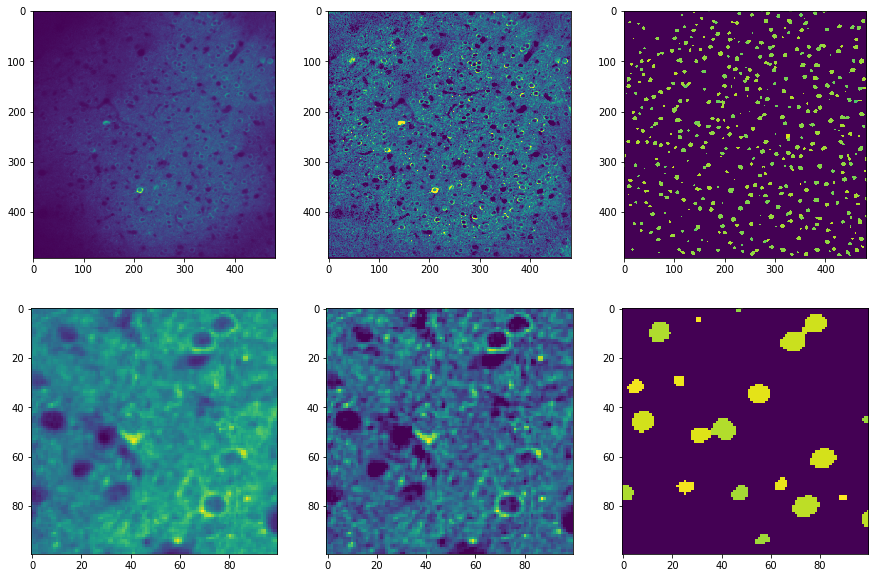

In [4]:
import segmentation.bl3d.utils as segutils

# Load stack (199 x 491 x 481 mm^3); this is corrected and rescaled to 1 um^3 per voxel
stack = np.load('../data/example1_17026-20-1.npy') # example not used during training
label = np.load('../data/label1_17026-20-1.npy')
enhanced = segutils.sharpen_2pimage(segutils.lcn(stack, (3, 30, 30))) # preprocessing done before training

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(stack[100])
axes[0, 1].imshow(enhanced[100])
axes[0, 2].imshow(label[100])
axes[1, 0].imshow(stack[100, 200:300, 200:300])
axes[1, 1].imshow(enhanced[100, 200:300, 200:300])
axes[1, 2].imshow(label[100, 200:300, 200:300])

/usr/local/lib/python3.5/dist-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


7066 initial cells
6360 final cells


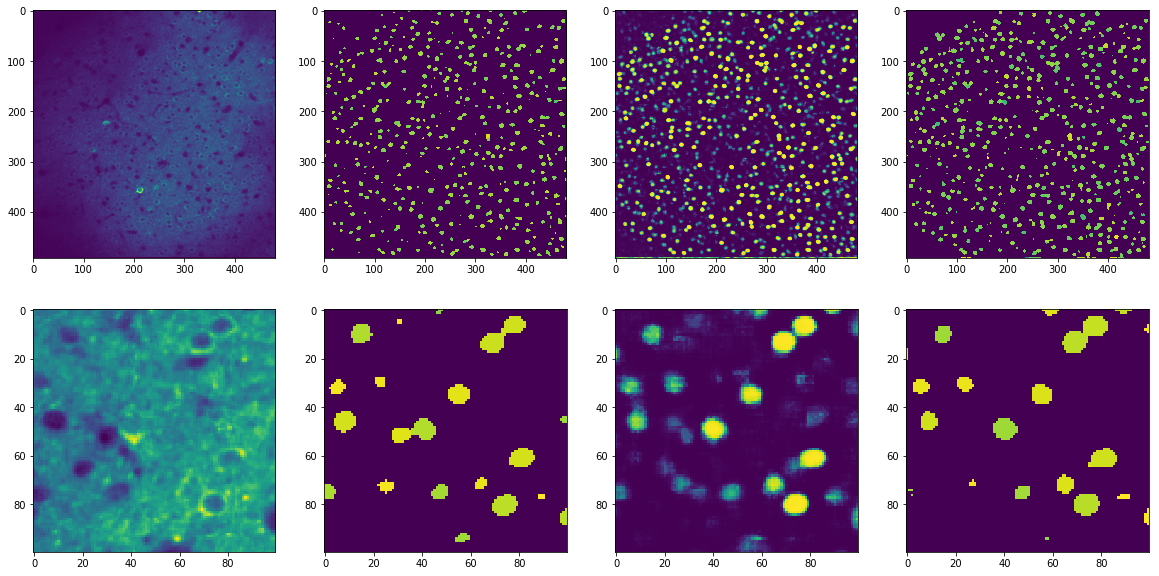

In [11]:
import segmentation.bl3d.evaluate as segevaluate
import torch.nn.functional as F

# Prepare input
norm = (enhanced - enhanced.mean()) / enhanced.std()
input_ = torch.as_tensor(norm[np.newaxis, np.newaxis, ...]).to(device) # 1 x 1 x D x H x W

# Segment
with torch.no_grad():
    logits = segevaluate.forward_on_big_input(net, input_)
    prediction = F.softmax(logits, dim=1)

# Convert to valid probs
probs = prediction[0, 1, :, :, :].numpy()

# Convert heatmap of probabilitles to instance segmentation
segmentation = segevaluate._prob2labels(probs)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0, 0].imshow(stack[100])
axes[0, 1].imshow(label[100])
axes[0, 2].imshow(probs[100])
axes[0, 3].imshow(segmentation[100])
axes[1, 0].imshow(stack[100, 200:300, 200:300])
axes[1, 1].imshow(label[100, 200:300, 200:300])
axes[1, 2].imshow(probs[100, 200:300, 200:300])
axes[1, 3].imshow(segmentation[100, 200:300, 200:300])

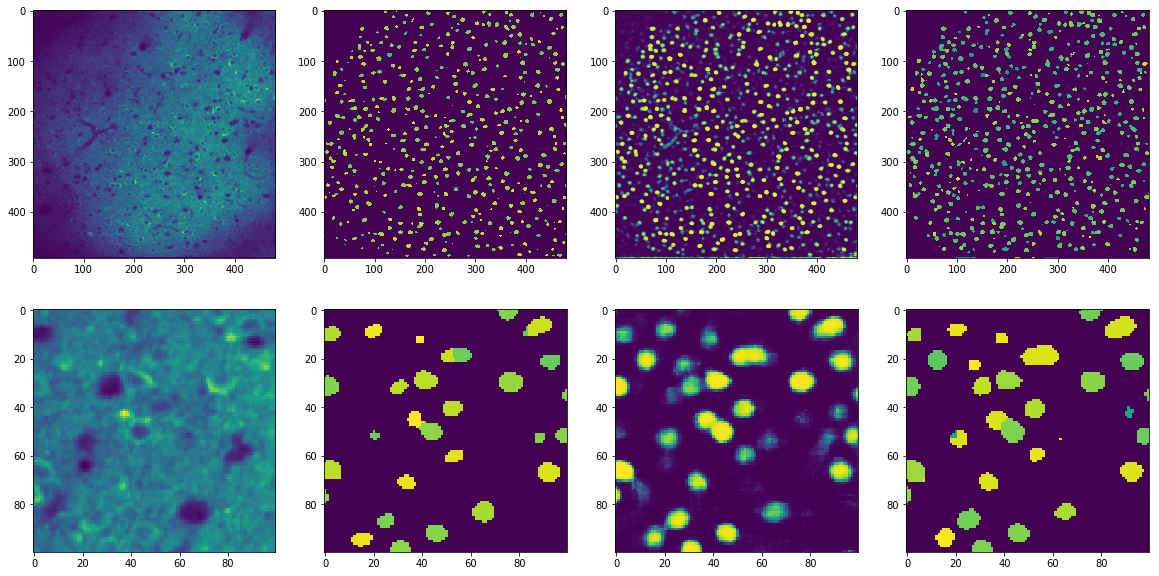

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0, 0].imshow(stack[50])
axes[0, 1].imshow(label[50])
axes[0, 2].imshow(probs[50])
axes[0, 3].imshow(segmentation[50])
axes[1, 0].imshow(stack[50, 200:300, 200:300])
axes[1, 1].imshow(label[50, 200:300, 200:300])
axes[1, 2].imshow(probs[50, 200:300, 200:300])
axes[1, 3].imshow(segmentation[50, 200:300, 200:300])

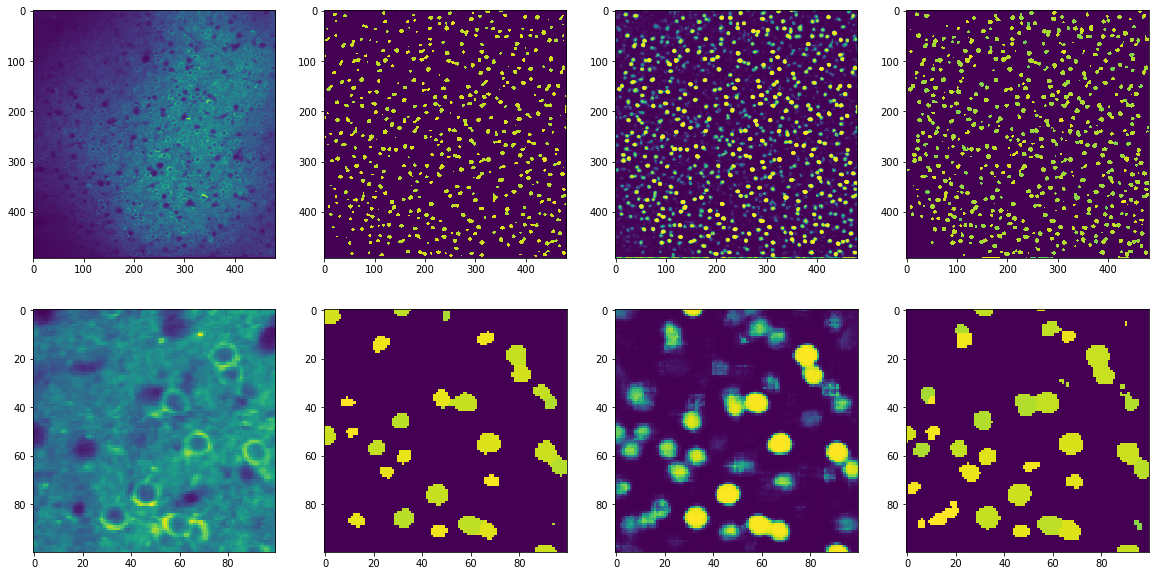

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0, 0].imshow(stack[150])
axes[0, 1].imshow(label[150])
axes[0, 2].imshow(probs[150])
axes[0, 3].imshow(segmentation[150])
axes[1, 0].imshow(stack[150, 200:300, 200:300])
axes[1, 1].imshow(label[150, 200:300, 200:300])
axes[1, 2].imshow(probs[150, 200:300, 200:300])
axes[1, 3].imshow(segmentation[150, 200:300, 200:300])